<a href="https://colab.research.google.com/github/blindTissue/NLP-Project/blob/main/bert_with_alibi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# alibi tensor from https://github.com/huggingface/transformers/blob/main/src/transformers/models/bloom/modeling_bloom.py#L756.
# This function creates an alibi tensor where each row 
def build_alibi_tensor(attention_mask: torch.Tensor, num_heads: int, dtype: torch.dtype) -> torch.Tensor:
    """
    Link to paper: https://arxiv.org/abs/2108.12409 Alibi tensor is not causal as the original paper mentions, it
    relies on a translation invariance of softmax for quick implementation: with l being a tensor, and a fixed value
    `softmax(l+a) = softmax(l)`. Based on
    https://github.com/ofirpress/attention_with_linear_biases/blob/a35aaca144e0eb6b789dfcb46784c4b8e31b7983/fairseq/models/transformer.py#L742
    TODO @thomasw21 this doesn't work as nicely due to the masking strategy, and so masking varies slightly.
    Args:
    Returns tensor shaped (batch_size * num_heads, 1, max_seq_len)
        attention_mask (`torch.Tensor`):
            Token-wise attention mask, this should be of shape (batch_size, max_seq_len).
        num_heads (`int`, *required*):
            number of heads
        dtype (`torch.dtype`, *optional*, default=`torch.bfloat16`):
            dtype of the output tensor
    """
    #print(attention_mask)
    batch_size, seq_length = attention_mask.shape
    closest_power_of_2 = 2 ** math.floor(math.log2(num_heads))
    base = torch.tensor(
        2 ** (-(2 ** -(math.log2(closest_power_of_2) - 3))), device=attention_mask.device, dtype=torch.float32
    )
    powers = torch.arange(1, 1 + closest_power_of_2, device=attention_mask.device, dtype=torch.int32)
    slopes = torch.pow(base, powers)

    if closest_power_of_2 != num_heads:
        extra_base = torch.tensor(
            2 ** (-(2 ** -(math.log2(2 * closest_power_of_2) - 3))), device=attention_mask.device, dtype=torch.float32
        )
        num_remaining_heads = min(closest_power_of_2, num_heads - closest_power_of_2)
        extra_powers = torch.arange(1, 1 + 2 * num_remaining_heads, 2, device=attention_mask.device, dtype=torch.int32)
        slopes = torch.cat([slopes, torch.pow(extra_base, extra_powers)], dim=0)

    # Note: alibi will added to the attention bias that will be applied to the query, key product of attention
    # => therefore alibi will have to be of shape (batch_size, num_heads, query_length, key_length)
    # => here we set (batch_size=1, num_heads=num_heads, query_length=1, key_length=max_length)
    # => the query_length dimension will then be broadcasted correctly
    # This is more or less identical to T5's relative position bias:
    # https://github.com/huggingface/transformers/blob/f681437203baa7671de3174b0fa583c349d9d5e1/src/transformers/models/t5/modeling_t5.py#L527
    arange_tensor = ((attention_mask.cumsum(dim=-1) - 1) * attention_mask)[:, None, :]
    alibi = slopes[..., None] * arange_tensor
    #print(alibi.reshape(batch_size * num_heads, 1, seq_length).to(dtype).shape)
    return alibi.reshape(batch_size * num_heads, 1, seq_length).to(dtype)

In [92]:
import torch
import torch.nn as nn
import math
import numpy as np


class BertEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config['vocab_size'], config['hidden_size'], padding_idx=config['pad_token_id'])

        self.LayerNorm = nn.LayerNorm(config['hidden_size'], eps=config['layer_norm_eps'])
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])

    def forward(self, input_ids):
        input_shape = input_ids.size()
        seq_length = input_shape[1]
        device = input_ids.device

        #position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
        #position_ids = position_ids.unsqueeze(0).expand(input_shape)
        #print(input_ids.shape)

        embeddings = self.word_embeddings(input_ids)

        embeddings = embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

class BertSelfAttention(nn.Module):
      def __init__(self, config):
        super().__init__()

        assert config["hidden_size"] % config["num_of_attention_heads"] == 0, "The hidden size is not a multiple of the number of attention heads"

        self.num_attention_heads = config['num_of_attention_heads']
        self.attention_head_size = int(config['hidden_size'] / config['num_of_attention_heads'])
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config['hidden_size'], self.all_head_size)
        self.key = nn.Linear(config['hidden_size'], self.all_head_size)
        self.value = nn.Linear(config['hidden_size'], self.all_head_size)

        self.dense = nn.Linear(config['hidden_size'], config['hidden_size'])

      def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

      def forward(self, hidden_states, attention_mask):
        mixed_query_layer = self.query(hidden_states)                             
        mixed_key_layer = self.key(hidden_states)                                
        mixed_value_layer = self.value(hidden_states)

        query_layer = mixed_query_layer.transpose(1, 2).reshape(1 * self.num_attention_heads, 512, self.attention_head_size)
        key_layer = self.transpose_for_scores(mixed_key_layer).reshape(1 * self.num_attention_heads, self.attention_head_size, 512)               
        value_layer = self.transpose_for_scores(mixed_value_layer)



        alibi = build_alibi_tensor( attention_mask, self.num_attention_heads, torch.float32)
        matmul_result = alibi.baddbmm(
            batch1=query_layer,
            batch2=key_layer,
            beta=1.0,
            alpha= 1.0 / math.sqrt(self.attention_head_size)
        )
        #print(matmul_result.shape)

        attention_scores = matmul_result.view(1, self.num_attention_heads, 512, 512)
        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs_reshaped = attention_probs.view(1 * self.num_attention_heads, 512, 512)
        context_layer = torch.matmul(attention_probs, value_layer)    
        #print(context_layer.shape)                    

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()            
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,) 
        context_layer = context_layer.view(*new_context_layer_shape)             
        
        output =  self.dense(context_layer)
        #print(output.shape)
        
        return output

class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config['hidden_size'], config['hidden_size'])
        self.LayerNorm = nn.LayerNorm(config['hidden_size'], eps=config['layer_norm_eps'])
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states
    
class BertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)
        
    def forward(self, input_tensor, attention_mask):
        self_output = self.self(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output

class BertIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config['hidden_size'], config['intermediate_size'])
        self.intermediate_act_fn = nn.GELU()

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states
    
class BertOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config['intermediate_size'], config['hidden_size'])
        self.LayerNorm = nn.LayerNorm(config['hidden_size'], eps=config['layer_norm_eps'])
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states
    
class BertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertAttention(config)
        self.intermediate = BertIntermediate(config)
        self.output = BertOutput(config)
        
    def forward(self, hidden_states, attention_mask):
        #print(hidden_states)
        attention_output = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

class BertEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer = nn.ModuleList([BertLayer(config) for _ in range(config['num_hidden_layers'])])
        
    def forward(self, hidden_states, attention_mask):
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states, attention_mask)
        return hidden_states
    
class BertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config['hidden_size'], config['hidden_size'])
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        #print(first_token_tensor.shape)
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output
    


class BertModel(nn.Module):
    def __init__ (self, config):
        super().__init__()
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
    def forward(self, input_ids, attention_mask):
        embedding_output = self.embeddings(input_ids)
        encoded_layers = self.encoder(embedding_output, attention_mask)
        sequence_output = encoded_layers
        pooled_output = self.pooler(sequence_output)
        return encoded_layers, pooled_output
    
class BertForBinaryClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config['hidden_dropout_prob'])
        self.classifier = nn.Linear(config['hidden_size'], 1)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits
    



hidden_size = 768
max_input_length = 512
#final config
config = {'hidden_size': hidden_size, 'num_of_attention_heads': 12, 'layer_norm_eps': 1e-12
          ,'hidden_dropout_prob': 0.1, 'num_hidden_layers': 3
          ,"intermediate_size": 3072, "hidden_act": "gelu", "hidden_dropout_prob": 0.1, "attention_probs_dropout_prob": 0.1
          ,"max_position_embeddings": 100, "type_vocab_size": 2, "initializer_range": 0.02,
          "vocab_size": 30522, "pad_token_id": 0}



In [46]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from datasets import load_dataset
from transformers import BertTokenizer, BertTokenizerFast

In [4]:
dataset = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
tokenizer = BertTokenizerFast.from_pretrained("Bert-base-uncased")

In [6]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [93]:
# randomInput = torch.randn(1, max_input_length , hidden_size)
# bertEncoder = BertEncoder(config)
# bertLayer = BertLayer(config)
# bertModel = BertModel(config)
bertForBinaryClassification = BertForBinaryClassification(config)
input = torch.tensor(tokenized_datasets['train'][0]['input_ids'])
mask = torch.tensor(tokenized_datasets['train'][0]['attention_mask'])

input = input.unsqueeze(0)
mask = mask.unsqueeze(0)
#print(mask.size())
#print(input.size())
print(bertForBinaryClassification(input, mask))

torch.Size([1, 12, 512, 512])
tensor([[-2.5473e-01,  1.3749e+00,  2.8290e+00,  ...,  7.2622e-01,
          2.5708e-01,  2.4452e-01],
        [-1.3172e+00,  3.6881e+00, -3.9561e-01,  ..., -2.6723e-01,
         -6.4251e-01, -2.2372e-01],
        [-2.6097e+00,  7.7108e-01,  7.9119e-01,  ..., -5.5420e-01,
         -3.1737e-01,  2.4289e-01],
        ...,
        [-3.6651e-01,  1.1005e+00,  8.5186e-01,  ..., -7.6204e-01,
          3.2287e-01,  5.4422e-02],
        [-1.7320e-01,  6.3961e-01,  1.0832e+00,  ...,  1.0147e-03,
          4.2042e-03, -2.5326e-03],
        [-1.7320e-01,  6.3961e-01,  1.0832e+00,  ...,  1.0147e-03,
          4.2042e-03, -2.5326e-03]], grad_fn=<SelectBackward0>)
torch.Size([1, 12, 512, 512])
tensor([[-2.0594, -0.1709,  3.5881,  ...,  1.2396,  2.2580,  2.6773],
        [ 3.2236,  0.5861,  0.0972,  ..., -4.6245, -3.3515, -4.9110],
        [ 0.5655,  2.4979,  1.4460,  ..., -0.1306,  0.3694, -0.2101],
        ...,
        [-0.4969, -1.6072,  5.1269,  ..., -1.9045, -0.6628

In [63]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        return self.dataset[idx]
    def select(self, idx):
        return self.dataset.select(idx)
    def shuffle(self):
        return self.dataset.shuffle()

train_dataset = CustomDataset(tokenized_datasets['train'])
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
shuffled_train_dataset = train_dataset.shuffle()

test_dataset = CustomDataset(tokenized_datasets['test'])
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
shuffled_test_dataset = test_dataset.shuffle()



trunc_dataset = shuffled_train_dataset.select(range(2000))
trunc_dataloader = DataLoader(trunc_dataset, batch_size=1, shuffle=True)

trunc_val_dataset = shuffled_test_dataset.select(range(1000))
trunc_val_dataloader = DataLoader(trunc_val_dataset, batch_size=1, shuffle=True)



In [64]:
for i in trunc_dataloader:
    print(i['input_ids'])
    print(i['label'])
    print(i['attention_mask'])
    break

[tensor([101]), tensor([1999]), tensor([2702]), tensor([2616]), tensor([2030]), tensor([2625]), tensor([2000]), tensor([6235]), tensor([2023]), tensor([2143]), tensor([1010]), tensor([6437]), tensor([9761]), tensor([18418]), tensor([3600]), tensor([2003]), tensor([2205]), tensor([16004]), tensor([1998]), tensor([2009]), tensor([2003]), tensor([2307]), tensor([999]), tensor([1996]), tensor([2143]), tensor([2003]), tensor([6919]), tensor([1010]), tensor([3272]), tensor([2005]), tensor([1996]), tensor([3383]), tensor([26997]), tensor([2098]), tensor([1011]), tensor([2006]), tensor([4566]), tensor([1010]), tensor([2021]), tensor([1045]), tensor([2293]), tensor([3407]), tensor([21306]), tensor([4312]), tensor([1012]), tensor([6437]), tensor([9761]), tensor([18418]), tensor([3600]), tensor([1010]), tensor([2174]), tensor([1010]), tensor([2004]), tensor([1996]), tensor([8899]), tensor([1011]), tensor([9081]), tensor([2751]), tensor([1011]), tensor([28661]), tensor([2003]), tensor([6429]), ten

In [65]:
from transformers import AdamW
#from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm


In [70]:

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    count = 0
    for d in tqdm(data_loader):
        count += 1
        input_ids = d["input_ids"]
        #input_ids = torch.tensor([torch.tensor(i) for i in input_ids])
        input_ids = torch.tensor(input_ids)
        input_ids = input_ids.unsqueeze(0)
        input_ids = input_ids.to(device)
        attention_mask = torch.tensor(d["attention_mask"]).unsqueeze(0).to(device)
        labels = d["label"].to(device)
        #print(labels)

        # Make sure you are using a sigmoid activation for binary classification
        outputs = torch.sigmoid(model(input_ids=input_ids, attention_mask=attention_mask))
        
        # Calculate the predictions by thresholding at 0.5
        preds = (outputs > 0.5).float()

        # Use binary cross-entropy loss for binary classification
        loss = loss_fn(outputs, labels.unsqueeze(1).float())
        correct_predictions += torch.sum(preds == labels.unsqueeze(1))
        optimizer.zero_grad()
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    return correct_predictions.cpu().double() / n_examples, np.mean(losses)

In [77]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BertForBinaryClassification(config).to(device)
optimizer = AdamW(model.parameters(), lr=3e-5)
epochs = 10
num_training_steps = epochs * len(train_dataloader)
loss_fn = nn.BCELoss().to(device)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [78]:
# train_acc, train_loss = train_epoch(
#         model,
#         trunc_dataloader,    
#         loss_fn, 
#         optimizer, 
#         device, 
#         lr_scheduler, 
#         len(trunc_dataset)
#     )

In [83]:
def evaluate(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"]
            input_ids = torch.tensor(input_ids)
            input_ids = input_ids.unsqueeze(0)
            input_ids = input_ids.to(device)
            attention_mask = torch.tensor(d["attention_mask"]).unsqueeze(0).to(device)
            labels = d["label"].to(device)
            outputs = torch.sigmoid(model(input_ids=input_ids, attention_mask=attention_mask))
            preds = (outputs > 0.5).float()
            loss = loss_fn(outputs, labels.unsqueeze(1).float())
            correct_predictions += torch.sum(preds == labels.unsqueeze(1))
            losses.append(loss.item())
    
    return correct_predictions.cpu().double() / n_examples, np.mean(losses)

In [84]:
def train(model, train_data_loader, val_data_loader, loss_fn, optimizer, device, scheduler, n_examples_train, n_examples_val, n_epochs):
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        print("-" * 10)

        train_accuracy, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, n_examples_train)
        val_accuracy, val_loss = evaluate(model, val_data_loader, loss_fn, device, n_examples_val)

        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

        print(f"Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}")
        print(f"Val Accuracy: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}")

    return {
        "train_accuracies": train_accuracies,
        "train_losses": train_losses,
        "val_accuracies": val_accuracies,
        "val_losses": val_losses
    }

In [85]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BertForBinaryClassification(config).to(device)
optimizer = AdamW(model.parameters(), lr=3e-5)
epochs = 10
num_training_steps = epochs * len(train_dataloader)
loss_fn = nn.BCELoss().to(device)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

history = train(model, trunc_dataloader, trunc_val_dataloader, loss_fn, optimizer, device, lr_scheduler, 2000, 1000, epochs)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
----------


100%|██████████| 2000/2000 [01:27<00:00, 22.85it/s]


Train Accuracy: 0.4855, Train Loss: 1.0888
Val Accuracy: 0.4800, Val Loss: 0.6984
Epoch 2/10
----------


100%|██████████| 2000/2000 [01:26<00:00, 23.04it/s]


Train Accuracy: 0.5390, Train Loss: 1.1817
Val Accuracy: 0.6210, Val Loss: 1.3507
Epoch 3/10
----------


100%|██████████| 2000/2000 [01:26<00:00, 23.04it/s]


Train Accuracy: 0.6820, Train Loss: 1.1911
Val Accuracy: 0.6440, Val Loss: 1.4167
Epoch 4/10
----------


100%|██████████| 2000/2000 [01:27<00:00, 22.93it/s]


Train Accuracy: 0.7495, Train Loss: 1.0266
Val Accuracy: 0.6590, Val Loss: 1.4704
Epoch 5/10
----------


100%|██████████| 2000/2000 [01:27<00:00, 22.87it/s]


Train Accuracy: 0.7885, Train Loss: 0.9262
Val Accuracy: 0.6810, Val Loss: 1.3976
Epoch 6/10
----------


100%|██████████| 2000/2000 [01:26<00:00, 23.12it/s]


Train Accuracy: 0.8385, Train Loss: 0.7571
Val Accuracy: 0.6530, Val Loss: 1.5239
Epoch 7/10
----------


100%|██████████| 2000/2000 [01:26<00:00, 23.08it/s]


Train Accuracy: 0.8930, Train Loss: 0.5383
Val Accuracy: 0.6700, Val Loss: 1.8309
Epoch 8/10
----------


100%|██████████| 2000/2000 [01:26<00:00, 23.14it/s]


Train Accuracy: 0.9405, Train Loss: 0.3314
Val Accuracy: 0.6590, Val Loss: 2.2540
Epoch 9/10
----------


100%|██████████| 2000/2000 [01:26<00:00, 23.00it/s]


Train Accuracy: 0.9610, Train Loss: 0.2356
Val Accuracy: 0.6450, Val Loss: 2.4719
Epoch 10/10
----------


100%|██████████| 2000/2000 [01:26<00:00, 23.11it/s]


Train Accuracy: 0.9750, Train Loss: 0.1578
Val Accuracy: 0.6500, Val Loss: 2.6083


In [86]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    train_accuracies = history['train_accuracies']
    train_losses = history['train_losses']
    val_accuracies = history['val_accuracies']
    val_losses = history['val_losses']
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(12, 5))

    # Plot accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label='Train', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Train', marker='o')
    plt.plot(epochs, val_losses, label='Validation', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

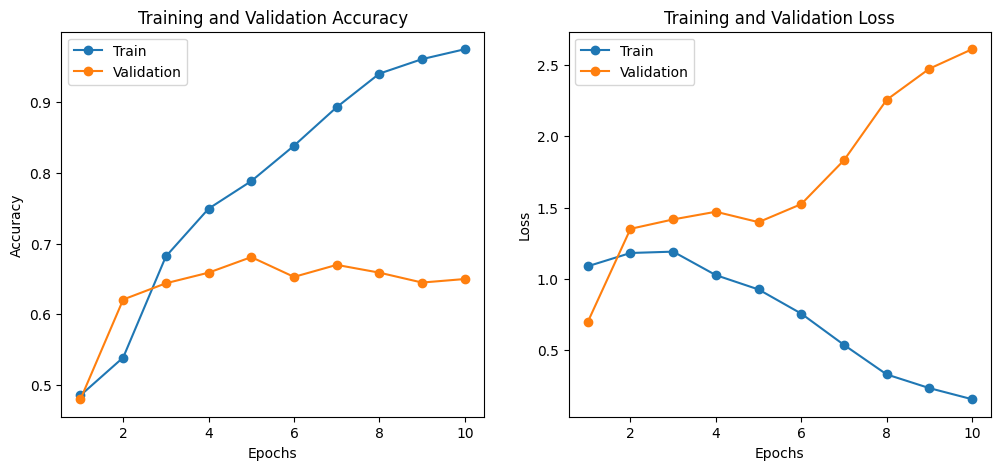

In [87]:
plot_metrics(history)